<h1 style='text-align: center;'> Independent Natural Language Processing Project 2 </h1> 
<h3 style='text-align: center;'> By Sri Das </h3>

<h2 style='text-align: center;'> Twitter data classification </h2>

### Importing packages

In [1]:
# Generic 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# NLP packages

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
# Modeling related packages

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### Loading and exploring data

In [4]:
data = pd.read_csv('tweet_data.csv')

In [5]:
data.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [6]:
data.shape

(785916, 18)

Checking and removing null values

In [7]:
data.isna().sum()

tweetID            0
crDate             0
edInput            0
editor             0
engages            0
isApproved         0
isEdNeed           0
isRT               0
likes              0
photoUrl      508020
retweets           0
rtUsID             0
text               0
topicName          0
usFlwrs            0
usID               0
usName             0
videoUrl      645425
dtype: int64

Most entries of features 'photourl' and 'videourl' are null values, so removing these columns from the data

In [8]:
data.dropna(axis='columns', inplace=True)

The description of data mentioned that a value of 1 for 'edInput' indicate correct classification of the data and 'edInput' value of 2 is incorrect classification of the data. The data is selected based on these two values for 'edInput' for 'Business' tweets. These two values of 'edInput' become the two classes. 

In [9]:
data_1 = (data[data['topicName'] == 'Business']).copy(deep=True)
data_1 =(data_1[(data_1['edInput']==1) | (data_1['edInput']==2)]).copy(deep=True)
data_1.reset_index(drop=True, inplace=True)
data_1['edInput'].value_counts()

1    17836
2    12188
Name: edInput, dtype: int64

A new variable 'target' is defined with a value 1 for correct classification of the tweets ('edInput' = 1) and 0 for the wrong classification ('edInput' = 0). 

In [10]:
data_1['target'] = 0
data_1.loc[data_1.edInput == 1, 'target'] = 1

The number of tweets correctly classified as 'Business' are 17836 and wrongly classified are 12188


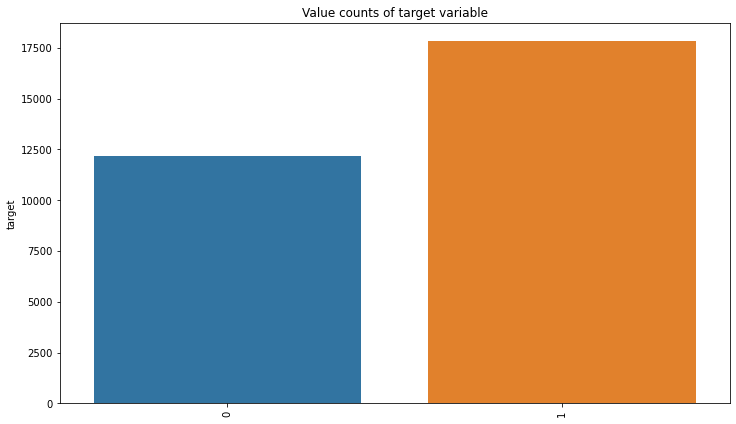

In [11]:
# Plotting the target values 

tar = data_1['target'].value_counts()
plt.figure(figsize = (12, 7))
plt.title('Value counts of target variable')
sns.barplot(x=tar.index, y=tar)
plt.xticks(rotation=90);

print("The number of tweets correctly classified as 'Business' are {} and wrongly classified are {}".format(tar[1], tar[0]))

The above figure shows that more business tweets are classified correctly

#### Word count of the tweets

In [12]:
data_1['word_count'] = data_1['text'].apply(lambda x: len(str(x).split()))
print('Average word count of target value 1:', data_1.loc[data_1.target==1]['word_count'].mean()) 
print('Average word count of target vallue 0:',data_1.loc[data_1.target ==0]['word_count'].mean())

Average word count of target value 1: 17.898912312177618
Average word count of target vallue 0: 17.262143091565473


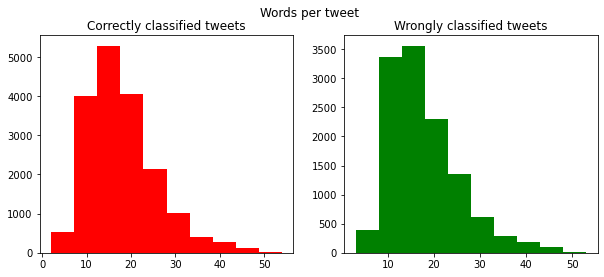

In [13]:
# Plotting word count of both classes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
bus_words=data_1[data_1['target']==1]['word_count']
ax1.hist(bus_words,color='red')
ax1.set_title('Correctly classified tweets')
nbus_words=data_1[data_1['target']==0]['word_count']
ax2.hist(nbus_words,color='green')
ax2.set_title('Wrongly classified tweets')
fig.suptitle('Words per tweet')
plt.show()

#### Character count of the tweets

In [14]:
data_1['char_count'] = data_1['text'].apply(lambda x: len(str(x)))
print('Average character count in Business tweets:',data_1[data_1['target']==1]['char_count'].mean()) 
print('Average character count in Non-business tweets:', data_1[data_1['target']==0]['char_count'].mean()) #Non-Business tweets

Average character count in Business tweets: 127.58662256111236
Average character count in Non-business tweets: 122.67812602559896


The average word and character count for both classes are almost the same. Let's look at the box plot of the character count of the tweets. 

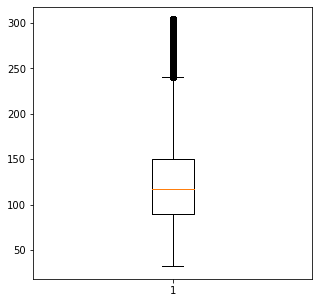

In [15]:
# Box plot of the character counts

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data_1.char_count)
plt.show()

As we can see from above results of character count, there are numerous outliers. Although the tweets have a limit of 140 characters, we can see there are many tweets with higher character counts. It is time to clean the tweet text. The below function 'text_clean' is used to remove any hyperlinks, punctuation and numbers from tweet text.

In [16]:
# Function to clean the text 
def text_clean(text) :
    text = text.lower() 
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'([^a-zA-Z\s]+?)', ' ', text) 
    text = re.sub(' +', ' ', text)
    text_clean = ' '.join( [w for w in text.split() if len(w)>1] )
    return text_clean

In [17]:
data_1['clean_text'] = data_1['text'].apply(text_clean)

### Vectorization

After the initial cleaning of the text, we move on to the next step of converting this text data into a format that can fed to the Machine learning algorithms, this process is called vectorization. Here two vectorization techniques, countvectorizer and TFIDF vectorizer are used.

In [18]:
# Finding the size of the vocabulary
vocab = []
for doc in data_1.clean_text:
    for word in doc.split():
        if word not in vocab:
            vocab.append(word)

In [19]:
print('Size of Vocabulary :', len(vocab))

Size of Vocabulary : 24070


In [20]:
# Splitting data into train and test

X = data_1['clean_text']
y = data_1['target']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, stratify=y)

#### Count vectorization

In [21]:
cvec = CountVectorizer()

X_train_cvec = cvec.fit_transform(X_train)

X_test_cvec = cvec.transform(X_test)

#### TFIDF vectorization

In [22]:
tfidf_vect = TfidfVectorizer(use_idf=True)
X_train_vect_tfidf = tfidf_vect.fit_transform(X_train) 
X_test_vect_tfidf = tfidf_vect.transform(X_test)


### Baseline model - Logistic Regression

#### Null accuracy

In [23]:
print(y_test.value_counts())
print('Null accuracy :', y_test.value_counts()[1]/(y_test.value_counts()[0] + y_test.value_counts()[1]))

1    3567
0    2438
Name: target, dtype: int64
Null accuracy : 0.5940049958368027


I have used Logistic Regression as the baseline model because of its simplicity, it is also linear and scalable to large data. Given the data is imbalanced 'accuracy' alone is not a good measure of performance. Hence other metrics such as precision, recall and confusion matrix are used to evaluate the model function.

In [24]:
# Function for logistic regression and performance metrics

def log_reg (X_train_vec, y_train, X_test_vec, y_test):
    lr_tfidf=LogisticRegression(class_weight='balanced', max_iter=1000)
    lr_tfidf.fit(X_train_vec, y_train) 

    #Predict y value for test dataset
    y_predict = lr_tfidf.predict(X_test_vec)
    y_prob = lr_tfidf.predict_proba(X_test_vec)[:,1]

    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))
 
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('\nAUC:', roc_auc)

In [25]:
# Baseline model on data after count vectorization
log_reg(X_train_cvec, y_train, X_test_cvec, y_test)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2438
           1       0.85      0.82      0.83      3567

    accuracy                           0.80      6005
   macro avg       0.80      0.80      0.80      6005
weighted avg       0.81      0.80      0.81      6005

Confusion Matrix:
 [[1915  523]
 [ 650 2917]]

AUC: 0.8807699233678146


In [26]:
# Baseline model on data after tfidf vectorization
log_reg(X_train_vect_tfidf, y_train, X_test_vect_tfidf, y_test)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2438
           1       0.86      0.81      0.83      3567

    accuracy                           0.81      6005
   macro avg       0.80      0.81      0.80      6005
weighted avg       0.81      0.81      0.81      6005

Confusion Matrix:
 [[1957  481]
 [ 671 2896]]

AUC: 0.8867074746106008


Based on the above results, it can be seen that TFIDF shows a marginal improvement in the model performance both in terms of accuracy and precision. 

### Factors affecting the model performance

The affect of different factors such as stopwords, n-grams, stemming and lemmatization on the performance of the base model is evaluated.

In [27]:
# Functions to caluculate accuracy wrt performance factors

def accu_summ(pipeline, X_train, y_train, X_test, y_test):
    accu_fit = pipeline.fit(X_train, y_train)
    y_pred = accu_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(classification_report(y_test,y_pred))
    return accuracy 

tfidf = TfidfVectorizer(use_idf=True)
lr = LogisticRegression(class_weight='balanced')
n_features = np.arange(1000,30000,5000)


def nfeat_accu_finder(vectorizer=tfidf, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        finder_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
       # print("Performance metrics {} features".format(n))
        nfeature_accuracy = accu_summ(finder_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

#### Stopwords

First we will look at how the inclusion and removal of stopwords affect the accuracy/performance of the model. 

In [28]:
# Feature analysis with stopwords removal
stpwrds = stopwords.words('english')
feat_wosw = nfeat_accu_finder(stop_words=stpwrds)

In [29]:
# Feature analysis with stopwords
feat_wsw = nfeat_accu_finder()

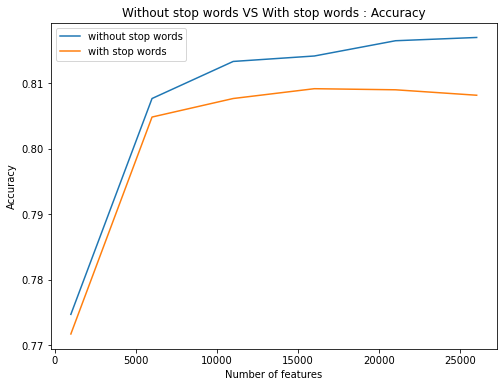

In [30]:
nfeat_plot_wosw = pd.DataFrame(feat_wosw,columns=['nfeat','val_accu'])
nfeat_plot_wsw = pd.DataFrame(feat_wsw,columns=['nfeat','val_accu'])
plt.figure(figsize=(8,6))
plt.plot(nfeat_plot_wosw.nfeat, nfeat_plot_wosw.val_accu, label='without stop words')
plt.plot(nfeat_plot_wsw.nfeat, nfeat_plot_wsw.val_accu,label='with stop words')
plt.title("Without stop words VS With stop words : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.legend();

The accuracy is marginally better without stopwords, for about 5000 value of 'max_features'. Beyond that, with feature values the accuracy without stop words improves more than accuracy with stop words

#### n-gram 

In the previous section the analysis was performed with unigram, in this section the performance of the model is calculated for bigram and trigram.

In [31]:
feat_bg = nfeat_accu_finder(ngram_range=(1, 2))

In [32]:
feat_tg = nfeat_accu_finder(ngram_range=(1, 3)) 

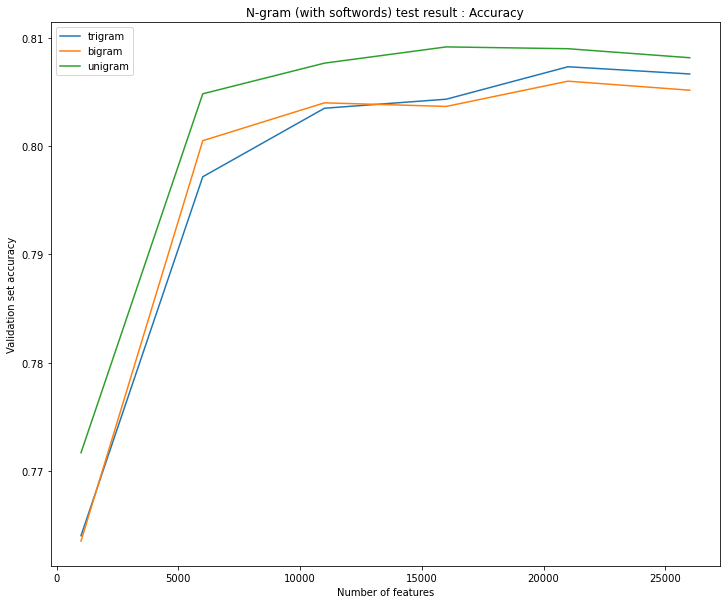

In [33]:
nfeat_plot_tg = pd.DataFrame(feat_tg,columns=['nfeat','val_accu'])
nfeat_plot_bg = pd.DataFrame(feat_bg,columns=['nfeat','val_accu'])
nfeat_plot_ug = pd.DataFrame(feat_wsw,columns=['nfeat','val_accu'])
plt.figure(figsize=(12,10))
plt.plot(nfeat_plot_tg.nfeat, nfeat_plot_tg.val_accu,label='trigram')
plt.plot(nfeat_plot_bg.nfeat, nfeat_plot_bg.val_accu,label='bigram')
plt.plot(nfeat_plot_ug.nfeat, nfeat_plot_ug.val_accu, label='unigram')

plt.title("N-gram (with softwords) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend();

The unigram gave better accuracy than bigram and trigram, while applied on baseline model

#### Stemming

In [34]:
stemmer = SnowballStemmer("english")

def stem(text):
    words = text.split()
    stems = [stemmer.stem(t) for t in words]
    return " ".join(stems)

In [35]:
data_1['text_stem'] = data_1.clean_text.apply(stem)

In [36]:
X_stem, y_stem = data_1['text_stem'], data_1['target']
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem , test_size=0.2, stratify=y_stem)

In [37]:
stem_vect = TfidfVectorizer(use_idf=True)
X_train_vec_stem = stem_vect.fit_transform(X_train_stem) 
X_test_vec_stem = stem_vect.transform(X_test_stem)

In [38]:
log_reg(X_train_vec_stem, y_train_stem, X_test_vec_stem, y_test_stem)

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      2438
           1       0.87      0.79      0.83      3567

    accuracy                           0.80      6005
   macro avg       0.80      0.81      0.80      6005
weighted avg       0.81      0.80      0.80      6005

Confusion Matrix:
 [[2007  431]
 [ 757 2810]]

AUC: 0.8866915483813547


There is no remarkable improvement in the performance metrics with stemming compared to baseline model

#### Lemmatization

In [39]:
wl = WordNetLemmatizer()

# Function to map NTLK position tags
def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemma(text):
    words = text.split()
    word_pos_tags = nltk.pos_tag(words) 
    a=[wl.lemmatize(tag[0], wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)

In [40]:
data_1['text_lemm'] = data_1.clean_text.apply(lemma)

In [41]:
X_lem, y_lem = data_1['text_lemm'], data_1['target']
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem,y_lem , test_size=0.2, stratify=y_lem)

In [42]:
lemm_vect = TfidfVectorizer(use_idf=True)
X_train_vectors_lemm = lemm_vect.fit_transform(X_train_lem) 
X_test_vectors_lemm = lemm_vect.transform(X_test_lem)

In [43]:
log_reg(X_train_vectors_lemm, y_train_lem, X_test_vectors_lemm, y_test_lem)

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2438
           1       0.87      0.81      0.84      3567

    accuracy                           0.81      6005
   macro avg       0.81      0.82      0.81      6005
weighted avg       0.82      0.81      0.81      6005

Confusion Matrix:
 [[2006  432]
 [ 687 2880]]

AUC: 0.8917817897309975


Lemmatization of the words of the data also does not improve the performance much compared to the baseline model. 

### Modeling

Apart from the logistic regression as baseline classifier, two other classifiers, Random forest classifier and Extreme gradient boosting classifiers are applied in this section. The performance of these models is evaluated on the vectorized data and results are compared. 

#### Random Forest Classifier

In [53]:
rfc = RandomForestClassifier()

In [54]:
rfc.fit(X_train_vect_tfidf, y_train)

RandomForestClassifier()

In [55]:
rfc_pred = rfc.predict(X_test_vect_tfidf)
y_prob_rfc = rfc.predict_proba(X_test_vect_tfidf)[:,1]


print(classification_report(y_test,rfc_pred))
print('Confusion Matrix:\n',confusion_matrix(y_test, rfc_pred))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rfc)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      2438
           1       0.79      0.87      0.83      3567

    accuracy                           0.78      6005
   macro avg       0.78      0.76      0.77      6005
weighted avg       0.78      0.78      0.78      6005

Confusion Matrix:
 [[1614  824]
 [ 471 3096]]

AUC: 0.8596331723691766


#### Extreme Gradient Boosting Classifier 

In [56]:
xgboost = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgboost.fit(X_train_vect_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [57]:
xgb_predict = xgboost.predict(X_test_vect_tfidf)
y_xgb_prob = xgboost.predict_proba(X_test_vect_tfidf)[:,1]


print(classification_report(y_test,xgb_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, xgb_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_xgb_prob)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      2438
           1       0.78      0.84      0.81      3567

    accuracy                           0.77      6005
   macro avg       0.76      0.75      0.75      6005
weighted avg       0.76      0.77      0.76      6005

Confusion Matrix:
 [[1615  823]
 [ 581 2986]]

AUC: 0.8486806987670454


 Both Random forest classifier and Extreme gradient boosting classifier show diminished performance. All the performance metrics, precision, recall, accuracy and AUC are lower compared to Logistic Regression model. However, between the two models Random forest classifier is better than XGB classifier. Based on the analysis so far it can be concluded that Logistc Regression Classifier is the best choice for modeling the classification of tweets. 

### Hyperparameter tuning

As Logistic Regression has been identified as the best performing model for this data set. We will perform hyperparameter tuning using GridSearch CV to improve upon the performance of the baseline model 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, stratify=y) 

In [59]:
tfidf = TfidfVectorizer()
X_train_vectors_tfidf = tfidf.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf.transform(X_test)

In [60]:
classifier = LogisticRegression(class_weight='balanced', max_iter=2000)

In [61]:
classifier.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 2000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [62]:
lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear', 'sag'],
          'C': np.logspace(-10,10,21)}

In [63]:
lr_model=GridSearchCV(classifier,param_grid=lr_params,
                            scoring='accuracy',cv=5,verbose=3)

In [64]:
lr_model.fit(X_train_vectors_tfidf,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END C=1e-10, penalty=l1, solver=liblinear;, score=0.406 total time=   0.0s
[CV 2/5] END C=1e-10, penalty=l1, solver=liblinear;, score=0.406 total time=   0.0s
[CV 3/5] END C=1e-10, penalty=l1, solver=liblinear;, score=0.406 total time=   0.0s
[CV 4/5] END C=1e-10, penalty=l1, solver=liblinear;, score=0.406 total time=   0.0s
[CV 5/5] END C=1e-10, penalty=l1, solver=liblinear;, score=0.406 total time=   0.0s
[CV 1/5] END .....C=1e-10, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END .....C=1e-10, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END .....C=1e-10, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END .....C=1e-10, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END .....C=1e-10, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=1e-10, penalty=l2, solver=liblinear;, score=0.741 total time=   0.0s
[CV 2/5] END C=1e-10, penalty

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100000.0, penalty=l2, solver=sag;, score=0.754 total time=   7.3s
[CV 5/5] END C=100000.0, penalty=l2, solver=sag;, score=0.767 total time=   6.5s
[CV 1/5] END C=1000000.0, penalty=l1, solver=liblinear;, score=0.739 total time=   0.2s
[CV 2/5] END C=1000000.0, penalty=l1, solver=liblinear;, score=0.732 total time=   0.2s
[CV 3/5] END C=1000000.0, penalty=l1, solver=liblinear;, score=0.729 total time=   0.3s
[CV 4/5] END C=1000000.0, penalty=l1, solver=liblinear;, score=0.717 total time=   0.2s
[CV 5/5] END C=1000000.0, penalty=l1, solver=liblinear;, score=0.727 total time=   0.2s
[CV 1/5] END .C=1000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END .C=1000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END .C=1000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END .C=1000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END .C=1000000.0, penalty=l1, solver=sag;, score=nan total time= 

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000000.0, penalty=l2, solver=sag;, score=0.753 total time=   7.3s
[CV 5/5] END C=1000000.0, penalty=l2, solver=sag;, score=0.768 total time=   6.8s
[CV 1/5] END C=10000000.0, penalty=l1, solver=liblinear;, score=0.735 total time=   0.2s
[CV 2/5] END C=10000000.0, penalty=l1, solver=liblinear;, score=0.726 total time=   0.3s
[CV 3/5] END C=10000000.0, penalty=l1, solver=liblinear;, score=0.719 total time=   0.4s
[CV 4/5] END C=10000000.0, penalty=l1, solver=liblinear;, score=0.714 total time=   0.3s
[CV 5/5] END C=10000000.0, penalty=l1, solver=liblinear;, score=0.725 total time= 8.0min
[CV 1/5] END C=10000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=10000000.0, penalty=l1, solver=sag;, score=nan total

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10000000.0, penalty=l2, solver=sag;, score=0.752 total time=   7.1s
[CV 5/5] END C=10000000.0, penalty=l2, solver=sag;, score=0.767 total time=   6.9s
[CV 1/5] END C=100000000.0, penalty=l1, solver=liblinear;, score=0.728 total time=   0.6s
[CV 2/5] END C=100000000.0, penalty=l1, solver=liblinear;, score=0.722 total time=   0.2s
[CV 3/5] END C=100000000.0, penalty=l1, solver=liblinear;, score=0.712 total time=   0.2s
[CV 4/5] END C=100000000.0, penalty=l1, solver=liblinear;, score=0.706 total time=   0.4s
[CV 5/5] END C=100000000.0, penalty=l1, solver=liblinear;, score=0.718 total time=   0.2s
[CV 1/5] END C=100000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=100000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=100000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=100000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=100000000.0, penalty=l1, solver=sag;, sco

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100000000.0, penalty=l2, solver=sag;, score=0.752 total time=   7.4s
[CV 5/5] END C=100000000.0, penalty=l2, solver=sag;, score=0.766 total time=   6.9s
[CV 1/5] END C=1000000000.0, penalty=l1, solver=liblinear;, score=0.724 total time=   0.5s
[CV 2/5] END C=1000000000.0, penalty=l1, solver=liblinear;, score=0.719 total time=   0.3s
[CV 3/5] END C=1000000000.0, penalty=l1, solver=liblinear;, score=0.709 total time=   0.2s
[CV 4/5] END C=1000000000.0, penalty=l1, solver=liblinear;, score=0.704 total time=   0.4s
[CV 5/5] END C=1000000000.0, penalty=l1, solver=liblinear;, score=0.716 total time=   0.2s
[CV 1/5] END C=1000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=1000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=1000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1000000000.0, penalty=l1, solv

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000000000.0, penalty=l2, solver=sag;, score=0.752 total time=   7.2s
[CV 5/5] END C=1000000000.0, penalty=l2, solver=sag;, score=0.767 total time=   7.0s
[CV 1/5] END C=10000000000.0, penalty=l1, solver=liblinear;, score=0.720 total time=   0.3s
[CV 2/5] END C=10000000000.0, penalty=l1, solver=liblinear;, score=0.718 total time=   0.3s
[CV 3/5] END C=10000000000.0, penalty=l1, solver=liblinear;, score=0.708 total time=   0.3s
[CV 4/5] END C=10000000000.0, penalty=l1, solver=liblinear;, score=0.706 total time=   0.3s
[CV 5/5] END C=10000000000.0, penalty=l1, solver=liblinear;, score=0.713 total time=   0.4s
[CV 1/5] END C=10000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10000000000.0, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=10000000000.0, pena

/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10000000000.0, penalty=l2, solver=sag;, score=0.754 total time=   7.3s
[CV 5/5] END C=10000000000.0, penalty=l2, solver=sag;, score=0.767 total time=   6.9s


/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
105 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/priyadas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logi

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000),
             param_grid={'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag']},
             scoring='accuracy', verbose=3)

In [65]:
lr_model.best_estimator_

LogisticRegression(C=10.0, class_weight='balanced', max_iter=2000, solver='sag')

In [66]:
lr_predict = lr_model.predict(X_test_vectors_tfidf)
y_lr_prob = lr_model.predict_proba(X_test_vectors_tfidf)[:,1]

In [67]:
print(classification_report(y_test,lr_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, lr_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_lr_prob)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2438
           1       0.86      0.83      0.85      3567

    accuracy                           0.82      6005
   macro avg       0.81      0.82      0.81      6005
weighted avg       0.82      0.82      0.82      6005

Confusion Matrix:
 [[1952  486]
 [ 596 2971]]

AUC: 0.8880863870871745


### Conclusions

A model is built for editor classified twitter data using NLP pipeline, with tweet text as the feature and editor classification as the target variable. After initial data exploration, the data is cleaned and vectotrized using count and TFIDF vectorizers. A baseline model is built using Logistic Regression and the two vectorizers are compared. Based on the results, TFIDF vectorizer is chosen for further analysis. Apart from accuracy, performance metrics such as precision, recall, confusion matrix and AUC are used to evaluate the results. The affect of factors such as stopwords, n-grams, stemming and lemmatization on the performance of the baseline model are studied. In the next step, two alternative models, Random forest classifier and Extrement gradient boosting models are built to classify the data. Based on all the performance metrics, it is concluded that the baseline model, Logist Regression has the best results and is chosen as the model of choice. To futher improve the Logist Regression model, hyperparameter tuning using GridsearchCV is performed. However, the gridsearch CV does not improve on the model performance by much.  

In this analysis, text from the tweets is used, as an extension to this project, adding other features such as 'username' and/or 'hashtags' to improve uppn the model performance. 

The model is built in this project to mimic the classfication of the editors, any errors by the editors will also be reflected in the model performance. As a next step, a model can be built to classify the data based on the categories and not editor inputs. This will circumvent some of the human errors during the classification process. It will be intersting to see how this model compares with the present (editor based) model.